# Abstract adversarial images synthesized using CMA-ES
This notebook shows how to synthesize abstract "paintings" through optimization. We use CMA-ES to optimize the corner positions of a number of rectangles. The objective function is the loss function of an MNIST image classifier network. In effect, we will synthesize images using the MNIST classifier as an "art critic". This allows us to understand what features the network finds essential. Depending on the painting method and network, the results can also be aesthetically interesting.

This is also called adversarial image synthesis, i.e., fooling a trained image classifier. In come cases, this can also be done using Tensorflow's optimizers like Adam, as shown in the  [AdversarialMNIST notebook](AdversarialMNIST.ipynb). However, CMA-ES provides more flexibility, as it does not require the drawing functions to be differentiable. Optimizing something else than raw pixels makes the adversarial images somewhat recognizable to human eye. 

NOTE: if your Anaconda environment does not have CMA-ES installed, use ```pip install cma``` from the terminal. You may also need ```pip install scikit-image``` for the drawing methods.

**Learning goals:**
* Using a convolutional neural network image classifier for image synthesis.  
* Using CMA-ES with the ```cma``` python package. 

**After you've read, run, and understood the code, try to modify it as follows to test your learning:**

* Easy: try modifying the network architecture. How does, e.g., omitting the dropout layers or adding or removing neurons affect the results?
* Easy: try changing the drawing style, e.g., use lines instead of rectangles.
* Slightly harder: try using some other image classifier network. For example, [this repository](https://github.com/geifmany/cifar-vgg) provides pre-trained networks for the CIFAR-10 and CIFAR-100 datasets, i.e., 32x32 pixel images of buildings, birds, boats etc. You should be able to load the pretrained .md5 models using the ```keras.models.load_model()``` method.
* Harder: train multiple networks and use their average output probabilities as the objective. How does this affect the results? Papers like [this one](https://arxiv.org/abs/1802.08195) suggest that using an ensemble of multiple networks is harder to fool by adversarial images. adding 1 or more fully connected layers, e.g., with 64 neurons before the output layer of the fully connected network example. How do the first layer weights look like now?
* Harder: Make the code run faster by querying the loss function values for a batch of images. This allows Tensorflow to more efficiently parallelize the computation. For this, you probably need to implement the network on a slightly lower level so that you can use sess.run(). See the [AdversarialMNIST notebook](AdversarialMNIST.ipynb) for an example.
* Hard: Implement the same in Unity. For example, if you optimize the pose of an animated character, can you make it's shadow appear as numbers, animals, etc.? For this, you need to use Tensorflow Sharp to load a pretrained classifier network and then feed a camera textures to the classifier. You can use the (LM-)MA-ES implementation provided in the course repository for the optimization.

As usual, model solutions are provided for the easy exercises, but please try to think of this as a puzzle game where you first try to solve the puzzles yourself and only check out the walkthrough if necessary.

## Training the MNIST classifier

First, let's load the MNIST dataset and train the classifier. See the [MNIST tutorial](MNIST.ipynb) for a more thoroughly commented version of the same code.

In [1]:
#The pylab inline below is something you may need to make images and plots visible in Jupyter, depending on your Anaconda setup
%pylab inline  
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense   
from tensorflow.keras.layers import Conv2D  
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten 
import cma  #this is the CMA-ES library

#Load the MNIST dataset, scale pixel values to 0...1, reshape
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train=np.reshape(x_train,[x_train.shape[0],x_train.shape[1],x_train.shape[2],1])
x_test=np.reshape(x_test,[x_test.shape[0],x_test.shape[1],x_test.shape[2],1])

#Build the network
model = keras.models.Sequential()
model.add(Conv2D(64, kernel_size=(5, 5), strides=[2,2],activation='relu',input_shape=(28,28,1,)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=[2,2]))
model.add(Conv2D(64, (3, 3), activation='relu', strides=[2,2]))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))



c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


Populating the interactive namespace from numpy and matplotlib
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 19s 321us/sample - loss: 0.7567 - acc: 0.7608 - val_loss: 0.1373 - val_acc: 0.9605

Now that the network is trained, we can proceed to the actual image synthesis. We first define some helper functions.

In [2]:
import skimage.draw as draw

#Line drawing helper
def drawLine(image:np.array,r0:int,c0:int,r1:int,c1:int,color:float=1.0):
    rr, cc = draw.line(r0,c0,r1,c1)
    image[rr, cc] = color

#Rectangle drawing helper
def drawRectangle(image:np.array,x0,y0,x1,y1,color:float=1.0):
    #rectangle(start, extent=extent, shape=img.shape)
    xmin=min([x0,x1])
    ymin=min([y0,y1])
    xmax=max([x0,x1])
    ymax=max([y0,y1])
    image[ymin:ymax+1,xmin:xmax+1]=color
    #rr,cc=draw.rectangle(start=(xmin,ymin),extent=(xmax-xmin,ymax-ymin),shape=image.shape)
    #image[rr, cc] = color
    
#Convert a single image to tensorflow image batch
def im2batch(image:np.array):
    return np.reshape(image,[1,image.shape[0],image.shape[1],1])


Running the optimization is easy as: 

1) We query for new **x** to evaluate using cmaes.ask()

2) Evaluate f(**x**) for each **x**

3) Feed the f(**x**) values back to the optimizer using cmaes.tell()

4) Repeat until maximum iteration count exceeded

However, we must first define some parameters.

Total number of optimized variables 12
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=976485, Mon Apr 22 21:54:51 2019)


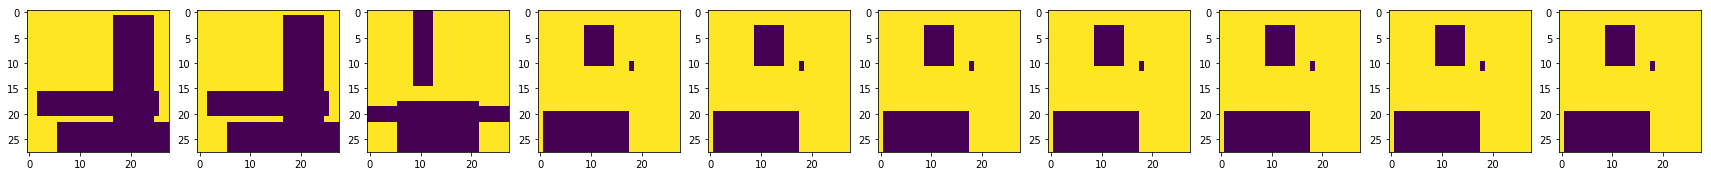

In [5]:
#This is how many primitives (in this case: rectangles) we will use
nPrimitives=3

#How many optimized variables per primitive. 
#In total, defining the corners of each rectangle requires 4 variables
nVarsPerPrimitive=4

#How many total optimized variables
nVars=nPrimitives*nVarsPerPrimitive
print("Total number of optimized variables",nVars)

#Width and height of optimized image, 28 for MNIST
imageReso=28

#Which image class we want to synthesize
targetClass=4

#Define CMA-ES population size
pop_size = 4 + int(3.0*math.log(nVars)) #recommended default for CMA-ES in Hansen's tutorial
pop_size*=20  #increase population size because this is a hard problem
cmaes_options = {'popsize': pop_size}  #the constructor below needs this

#Define initial mean and standard deviation for the variables.
#These should be set such that the initial Gaussian distribution of CMA-ES covers the whole range
#We use 0 and 1, as we will later use np.sin() or np.tanh() to clamp the values to valid range
startingMean=0
startingSigma=1

#Create the CMA-ES optimizer
cmaes=cma.CMAEvolutionStrategy(np.ones(nVars)*startingMean, startingSigma, inopts=cmaes_options)

#Variables for remembering the best painting and f(x) value found so far
bestArt=None
bestFx=np.inf

#The main optimization loop
nIter=10
pp.figure(1,figsize=[nIter*3,3])
for iter in range(nIter):
    #Ask for a batch of x
    xBatch=cmaes.ask()
    
    #Array to hold the f(x) values
    fxBatch=[]
    
    #Loop over the batch
    for x in xBatch:
        #Create the drawing:
        #First initialize the image to constant color
        art=np.ones(shape=[imageReso,imageReso])
        
        #Make sure that the x given by CMA-ES stays within limits
        #You can also try the other two options for slightly different results
        x=0.5+0.5*np.sin(x)    #clip without saturating
        #x=0.5+0.5*np.tanh(x)  #clip with soft saturation
        #x=0.5+0.5*np.clip(x,-1,1) #hard clip
        
        #Now, we scale to image coordinates. We multiply x with slightly less than 1 to ensure that
        #we stay in the range 0...imageReso-1 after converting to integers
        x=0.999*imageReso*x
        
        #Draw all the rectangles by increasing the brightness of pixel values
        for i in np.arange(0,nVarsPerPrimitive*nPrimitives,nVarsPerPrimitive):
            #Draw
            drawRectangle(art,int(x[i]),int(x[i+1]),int(x[i+2]),int(x[i+3]),color=0)
            #Ensure that brightness stays within bounds
            #art=np.clip(art,0,1)

        #Evaluate the fitness function value. 
        #model.evaluate() gives us the loss function value and classification accuracy,
        #thus model.evaluate()[0] is the loss function value, which we use as the f(x) minimized by CMA-ES 
        labelBatch=np.zeros(shape=[1,1])
        labelBatch[0,0]=targetClass
        fx=model.evaluate(im2batch(art), labelBatch, verbose=0)[0]
        fxBatch.append(fx)

        #If we found anew best value, remember the painting for visualization
        if fx<bestFx:
            bestFx=fx
            bestArt=art.copy()
    
    #Feed the objective function values back to CMA-ES
    cmaes.tell(solutions=xBatch,function_values=fxBatch)
    
    #Print progress
    print("iter ",iter," best f(x) ",bestFx,end='\r')

    #Visualize
    pp.subplot(1,nIter,1+iter)
    pp.imshow(bestArt)
        
    

Below is a version that optimizes a whole MNIST "font"

Total number of optimized variables 12
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1071762, Mon Apr 22 21:57:13 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1022509, Mon Apr 22 21:57:20 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1041925, Mon Apr 22 21:57:27 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=987303, Mon Apr 22 21:57:36 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1077188, Mon Apr 22 21:57:43 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1049050, Mon Apr 22 21:57:52 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1080283, Mon Apr 22 21:57:59 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1096591, Mon Apr 22 21:58:06 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1076975, Mon Apr 22 21:58:13 2019)
(110_w,220)-aCMA-ES (mu_w=57.7,w_1=4%) in dimension 12 (seed=1100461, Mon Apr 22 21:58:20 2019)


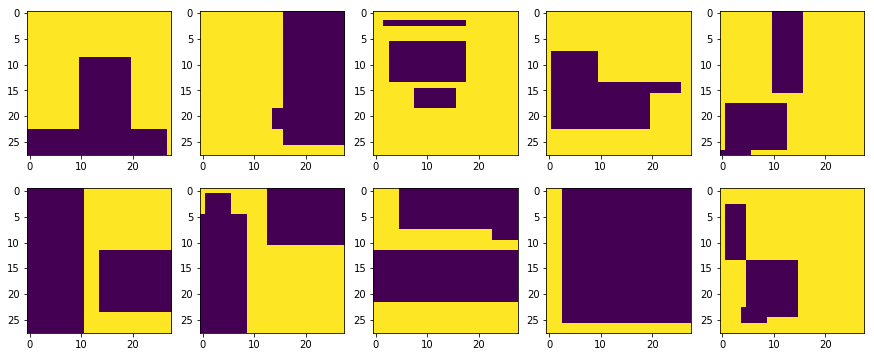

In [7]:
#This is how many primitives (in this case: rectangles) we will use
nPrimitives=3

#How many optimized variables per primitive. 
#In total, defining the corners of each rectangle requires 4 variables
nVarsPerPrimitive=4

#How many total optimized variables
nVars=nPrimitives*nVarsPerPrimitive
print("Total number of optimized variables",nVars)

#Width and height of optimized image, 28 for MNIST
imageReso=28

#Define CMA-ES population size
pop_size = 4 + int(3.0*math.log(nVars)) #recommended default for CMA-ES in Hansen's tutorial
pop_size*=20  #increase population size because this is a hard problem
cmaes_options = {'popsize': pop_size}  #the constructor below needs this

#Define initial mean and standard deviation for the variables.
#These should be set such that the initial Gaussian distribution of CMA-ES covers the whole range
#We use 0 and 1, as we will later use np.sin() or np.tanh() to clamp the values to valid range
startingMean=0
startingSigma=1

#We will produce a 5-by-2 grid figure
pp.figure(1,figsize=[5*3,2*3])

#Loop over all 10 MNIST classes
for targetClass in range(10):
    #Create the CMA-ES optimizer
    cmaes=cma.CMAEvolutionStrategy(np.ones(nVars)*startingMean, startingSigma, inopts=cmaes_options)

    #Variables for remembering the best painting and f(x) value found so far
    bestArt=None
    bestFx=np.inf

    #The main optimization loop
    for iter in range(10):
        #Ask for a batch of x
        xBatch=cmaes.ask()

        #Array to hold the f(x) values
        fxBatch=[]

        #Loop over the batch
        for x in xBatch:
            #Create the drawing:
            #First initialize the image to constant color
            art=np.ones(shape=[imageReso,imageReso])

            #Make sure that the x given by CMA-ES stays within limits
            #You can also try the other two options for slightly different results
            x=0.5+0.5*np.sin(x)    #clip without saturating
            #x=0.5+0.5*np.tanh(x)  #clip with soft saturation
            #x=0.5+0.5*np.clip(x,-1,1) #hard clip

            #Now, we scale to image coordinates. We multiply x with slightly less than 1 to ensure that
            #we stay in the range 0...imageReso-1 after converting to integers
            x=0.999*imageReso*x

            #Draw all the rectangles by increasing the brightness of pixel values
            for i in np.arange(0,nVarsPerPrimitive*nPrimitives,nVarsPerPrimitive):
                #Draw
                drawRectangle(art,int(x[i]),int(x[i+1]),int(x[i+2]),int(x[i+3]),color=0)
                #Ensure that brightness stays within bounds
                #art=np.clip(art,0,1)

            #Evaluate the fitness function value. 
            #model.evaluate() gives us the loss function value and classification accuracy,
            #thus model.evaluate()[0] is the loss function value, which we use as the f(x) minimized by CMA-ES 
            labelBatch=np.zeros(shape=[1,1])
            labelBatch[0,0]=targetClass
            fx=model.evaluate(im2batch(art), labelBatch, verbose=0)[0]
            fxBatch.append(fx)

            #If we found anew best value, remember the painting for visualization
            if fx<bestFx:
                bestFx=fx
                bestArt=art.copy()

        #Feed the objective function values back to CMA-ES
        cmaes.tell(solutions=xBatch,function_values=fxBatch)

        #Print progress
        print("optimizing number ",targetClass,", iteration ",iter," best f(x) ",bestFx,end='\r')

    #Visualize
    pp.subplot(2,5,1+targetClass)
    pp.imshow(bestArt)

